Try out our kNN bootstrap method on the degree heterogeneous international trade data. 

Will bootstrap the 2020 data, then can compare it to 2021 for the whole, is this the same?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from tqdm import tqdm
import random

In [2]:
folder = "/home/uj21900/Documents/CommonCrawlData/InternationalTradeData/"

In [3]:
# Read in the export data from 2016 to 2021
M_2016_2021_list = []
for t in range(2016,2022):
    filename = folder + 'M_export_' + str(t) + '.csv'
    df = pd.read_csv(filename)
    M = np.array(df)
    M_2016_2021_list.append(M)

In [4]:
# read in the export indices names
total = pd.read_csv(folder+'exportMatricesIndices.csv', header=None)

total = list(total[0])

In [5]:
M_2016_2021_list
n = M_2016_2021_list[0].shape[0]
T = len(M_2016_2021_list)
print(n,T)

144 6


In [6]:
# put A_list into a 3D array
As = np.zeros((T,n,n))
for t in range(T):
    As[t,:,:] = M_2016_2021_list[t]

In [7]:
# read in inflation rate data, at a world level
# https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG
inflationrates = pd.read_csv(folder+'worldbank_inflationRateData.csv')

worldIR = inflationrates[inflationrates['Country Name']=='World']

In [8]:
worldIR = worldIR.iloc[:, -(T+1):]
# remove the last column as it's for 2022
worldIR = worldIR.iloc[:, :-1]
worldIR = worldIR.reset_index(drop=True)
worldIR

,2016,2017,2018,2019,2020,2021
0,1.550016,2.19201,2.438737,2.206073,1.928955,3.475403


In [9]:
# put the values in a list
worldIRlist = list(worldIR.iloc[0,:])

# want it to be the proportion, i.e, 3% = 1.03
worldIRlist_prop = [x/100 + 1 for x in worldIRlist]

In [10]:
IRadj_As = np.zeros((T,n,n))

from functools import reduce

for t in range(T):
    mat = As[t]
    cumulative_inflation = worldIRlist_prop[(t+1):T]
    # multiply all items in a list
    if len(cumulative_inflation) > 0:
        cumulative_inflation = reduce(lambda x, y: x*y, cumulative_inflation)
    else:
        cumulative_inflation = 1
    mat = mat*cumulative_inflation
    IRadj_As[t] = mat

In [11]:
# LOOK AT 2020
A_2020 = IRadj_As[4]
d=2
ya = UASE([A_2020], d)
# plot_embedding(ya, n, 1, np.ones(n))

In [13]:
yadf = pd.DataFrame(ya)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
# give each node a number
yadf['node_number'] = list(range(n))
yadf['country'] = total

In [14]:
fig = px.scatter(yadf, x="Dimension_1", y="Dimension_2",
                hover_data=["country", "node_number"],
                color_continuous_scale = 'Bluered', title=f"The A matrix for 2020 embedded, with UASE d={d}")

fig.show()

In [15]:
# make some unweighted networks
binary_As = []
for A in IRadj_As:
    A_bin = A.copy()
    A_bin[A_bin > 0] = 1
    binary_As.append(A_bin)

In [59]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Australia", "Austria", "Azerbaijan", "Belarus", 
    "Belgium", "Bosnia Herzegovina", "Bulgaria", "Canada", "Croatia", "Czechia", 
    "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", 
    "Iceland", "Ireland", "Italy", "Latvia", "Lichtenstein", "Lithuania", "Luxembourg", 
    "Malta", "Monaco", "Montenegro", "Netherlands", "New Zealand", "North Macedonia", 
    "Norway", "Poland", "Portugal", "Rep. of Moldova", "Romania", "Russian Federation", 
    "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", 
    "T�rkiye", "Ukraine", "United Kingdom", 
]

#https://www.un.org/dgacm/en/content/regional-groups
# israel, turkiye and US had stars, just kept turkiye

In [60]:
len(europecountries)

50

In [62]:
# which european countries are not in the total list
for c in european_countries:
    if c not in total:
        print(c)

# these are all really tiny so must have either not been, or were excluded from the data

Lichtenstein
Monaco
San Marino


In [64]:
eu_countries_in_data = [c for c in european_countries if c in total]
len(eu_countries_in_data)

47

In [69]:
# find indexes of total where the value is in eu_countries_in_data
eu_indexes = [total.index(c) for c in eu_countries_in_data]

In [71]:
binary_A_eu = []
for A in binary_As:
    A_eu = A[eu_indexes][:,eu_indexes]
    binary_A_eu.append(A_eu)

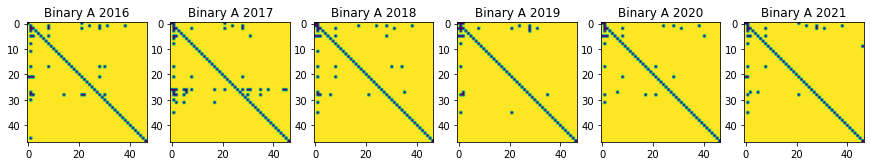

In [75]:
# plot in one figure the heatmaps for the binary networks
fig, axs = plt.subplots(1,6, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(binary_A_eu[i])
    ax.set_title(f"Binary A {2016+i}")